In [1]:
from itertools import product
from itertools import combinations

import os

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, ConcatDataset

import random
import ast
        

import torch.nn.functional as F
#from torcheval.metrics.functional import multiclass_confusion_matrix
from torch.optim import Adam ,SGD ,Adadelta
from torch.nn import CrossEntropyLoss

from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import transforms

import optuna

from itertools import product
from itertools import combinations


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation ,FFMpegWriter ,PillowWriter

import dill
import numpy as np

import json
import pandas as pd
from tqdm import tqdm
import copy
import os 
import random

from collections import OrderedDict
import wandb


In [2]:
#!pip install wandb

In [3]:
wandb.login(key="ab631efc36e2c87f5f54d82b5cdbd6c501d5221f")

wandb: Currently logged in as: aymentlili. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/crns/.netrc


True

In [4]:
import accelerate

In [5]:
#!accelerate config

In [6]:
seed=74
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
from Double_input_transformer import CustomDataset,TransformerAE

# Trainloader code

In [8]:

# Load the list
train_pair2 = np.load('train_pair++.npy', allow_pickle=True)
test_pair2 = np.load('test_pair++.npy', allow_pickle=True)
val_pair2 = np.load('val_pair++.npy', allow_pickle=True)
train_pair2 = [ list(x) for x in train_pair2]
test_pair2 = [ list(x) for x in test_pair2]
val_pair2 = [ list(x) for x in val_pair2]
random.shuffle(train_pair2)
random.shuffle(test_pair2)
random.shuffle(val_pair2)

In [9]:
def batchify(lst, batch_size):
    return [lst[i:i+batch_size] for i in range(0, len(lst), batch_size)]

# Example usage:
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
batch_size = 4
batches = batchify(my_list, batch_size)
print(batches)

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10]]


In [10]:
len(train_pair2),len(test_pair2),len(val_pair2)

(15822, 3743, 3871)

In [11]:
All = list(train_pair2)+list(test_pair2)+list(val_pair2)
All = [ list(x) for x in All]
All.sort(reverse=True)
len(All)

23436

In [12]:

# train_pair2=[]
# test_pair2=[]
# val_pair2=[]
# for i,L1 in tqdm(enumerate(All)) :
#     matches=[]
#     for L2 in All :
#         if L2[2]==4 and L2[3]==0 and L1[2]==4 and L1[3]==0 and L1[0]==L2[0] and L2 not in matches and L2 not in train_pair2 and L2 not in test_pair2  and L2 not in val_pair2 :
#             matches.append(L2)
#     train_pair2.extend(matches[:int(len(matches)*0.7)])
#     test_pair2.extend(matches[int(len(matches)*0.7):int(len(matches)*0.85)])
#     val_pair2.extend(matches[int(len(matches)*0.85):])
#     if L1[0]==[0,1,2,3,4,5,6,7] :
#         print(len(matches))
# print(len(train_pair2))
# print(len(test_pair2))
# print(len(val_pair2))

In [13]:
#cs_tr=CustomDataset(train_pair,batch_size=200)

In [14]:
#Dataset,EXP,ACC,U = cs_tr[0]
#x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]

In [15]:
#x1.shape
random.shuffle(train_pair2)
train_pair2[:2]

[[[0, 1, 6, 7, 9], [2, 5, 8], 4, 0], [[0, 4, 5, 6, 7, 8], [1, 9], 4, 0]]

In [16]:
# All = list(train_pair)+list(test_pair)+list(val_pair)
# All = [ list(x) for x in All]
# train_pair=[]
# test_pair=[]
# val_pair=[]
# for L1 in tqdm(All) :
#     matches=[]
#     for L2 in All :
#         if L1[0]==L2[0] and L2 not in matches and L2[2]==4 and L2[3]==0 :
#             matches.append(L2)
#     train_pair.extend(matches[:int(len(matches)*0.7)])
#     test_pair.extend(matches[int(len(matches)*0.7):int(len(matches)*0.85)])
#     val_pair.extend(matches[int(len(matches)*0.85):])

    

In [17]:
# val_pair=test_pair[int(len(test_pair)/2):]
# test_pair=test_pair[:int(len(test_pair)/2)]


In [18]:
val_pair2[0] ,len(train_pair2)

([[0, 1, 3], [2, 4, 5, 7], 4, 0], 15822)

In [19]:
# np.save("train_pair++", train_pair2)
# np.save("test_pair++", test_pair2)
# np.save("val_pair++", val_pair2)

# Autoencoder

In [20]:
#!pip install einops

In [21]:
class EmbedderNeuronGroup(nn.Module):
    def __init__(self, d_model, seed=22):
        super().__init__()
        #print("EmbedderNeuroneGroup")
        self.neuron_l1 = nn.Linear(200, d_model) #8
        self.neuron_l2 = nn.Linear(72, d_model) #12

    def forward(self, x):
        return self.multiLinear(x)

    def multiLinear(self, v):
        #print("multi-linear method",v.shape)

        l = []

        for ndx in range(8):
            idx_start = ndx * 200
            idx_end = idx_start + 200
            l.append(self.neuron_l1(v[:,idx_start:idx_end]))

        # l2
        for ndx in range(12):
            idx_start = 200*8 + ndx * 72
            idx_end = idx_start + 72
            l.append(self.neuron_l2(v[:,idx_start:idx_end]))
        #print(len(l))
        #print(len(l[0]))
        final = torch.stack(l, dim=1)

        # print(final.shape)
        return final



In [22]:
# max_seq_len=176,
# N=4
# heads=3
# d_model=900
# d_ff=900
# neck=700
# dropout=0.1
# # Enc=EncoderNeuronGroup(d_model=d_model, N=N, heads=heads, max_seq_len=max_seq_len, dropout=dropout,d_ff=d_ff)
# # vec1 = torch.rand(1,2464)
# # res,scores=Enc(vec1)
# # res.shape

In [23]:
# vec2neck = nn.Linear(d_ff*2, neck)
# print(res.shape)
# out3=torch.cat([res,res], dim=2)
# print("neck input:",out3.shape)
# sum_r=torch.sum(out3, dim=1, keepdim=False)
# vec2=vec2neck(sum_r)
# print(len(vec2))
# tanh = nn.Tanh()
# neck_t=tanh(vec2)
# print("neck shape:",neck_t.shape)

In [24]:
# Dec=DecoderNeuronGroup(d_model=d_model, N=N, heads=heads, max_seq_len=max_seq_len, dropout=dropout,d_ff=d_ff,neck=neck)
# res,scores=Dec(neck_t)
# res.shape

In [25]:
len(test_pair2),len(train_pair2),len(val_pair2)#,len(test_tgt),len(train_tgt),len(val_tgt)

(3743, 15822, 3871)

In [26]:
#test_pair=[ x for x in test_pair  if (0 in x[0]) and (1 in x[0]) and (2 in x[0] or 2 in x[1] ) and (3 in[0] or 2 in x[1]) and (4 in[0] or 2 in x[1] ) ]
#len(test_pair)

In [27]:
from torchvision import datasets
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

class ClassSpecificImageFolder(datasets.DatasetFolder):
    def __init__(
            self,
            root,
            dropped_classes=[],
            transform = None,
            target_transform = None,
            loader = datasets.folder.default_loader,
            is_valid_file = None,
    ):
        self.dropped_classes = dropped_classes
        super(ClassSpecificImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                                       transform=transform,
                                                       target_transform=target_transform,
                                                       is_valid_file=is_valid_file)
        self.imgs = self.samples

    def find_classes(self, directory):
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        classes = [c for c in classes if c not in self.dropped_classes]
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [28]:


# print(mod.numParams())
# x1 = torch.rand(1,2464)
# x2 = torch.rand(1,2464)
# mod=mod.to(device).to(torch.float32)

# #x1=x1.to(torch.float32)
# #x2=x2.to(torch.float32)
# x1=x1.to(device)
# x2=x2.to(device)
# mod=mod.to(device)
# out = mod(x1,x2)
# print("Output Shape: ", out[0].shape)

# from torchinfo import summary

# summary(mod)


In [29]:


#from torcheval.metrics.functional import multiclass_confusion_matrix

class CNN(nn.Module):
    def __init__(
        self,
        channels_in,
        nlin="leakyrelu",
        dropout=0.0,
        init_type="uniform",
    ):
        super().__init__()
        # init module list
        self.module_list = nn.ModuleList()
        ### ASSUMES 28x28 image size
        ## compose layer 1
        self.module_list.append(nn.Conv2d(channels_in, 8, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        # apply dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 2
        self.module_list.append(nn.Conv2d(8, 6, 5))
        self.module_list.append(nn.MaxPool2d(2, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## compose layer 3
        self.module_list.append(nn.Conv2d(6, 4, 2))
        self.module_list.append(self.get_nonlin(nlin))
        ## add flatten layer
        self.module_list.append(nn.Flatten())
        ## add linear layer 1
        self.module_list.append(nn.Linear(3 * 3 * 4, 20))
        self.module_list.append(self.get_nonlin(nlin))
        ## add dropout
        if dropout > 0:
            self.module_list.append(nn.Dropout(dropout))
        ## add linear layer 1
        self.module_list.append(nn.Linear(20, 10))

        ### initialize weights with se methods
        self.initialize_weights(init_type)

    def initialize_weights(self, init_type):
        # print("initialze model")
        for m in self.module_list:
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                if init_type == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                if init_type == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                if init_type == "uniform":
                    torch.nn.init.uniform_(m.weight)
                if init_type == "normal":
                    torch.nn.init.normal_(m.weight)
                if init_type == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight)
                if init_type == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight)
                # set bias to some small non-zero value
                m.bias.data.fill_(0.01)

    def get_nonlin(self, nlin):
        # apply nonlinearity
        if nlin == "leakyrelu":
            return nn.LeakyReLU()
        if nlin == "relu":
            return nn.ReLU()
        if nlin == "tanh":
            return nn.Tanh()
        if nlin == "sigmoid":
            return nn.Sigmoid()
        if nlin == "silu":
            return nn.SiLU()
        if nlin == "gelu":
            return nn.GELU()


    def forward(self, x):
        # forward prop through module_list
        for layer in self.module_list:
            x = layer(x)
        return x

    def forward_activations(self, x):
        # forward prop through module_list
        activations = []
        for layer in self.module_list:
            x = layer(x)
            if (
                isinstance(layer, nn.Tanh)
                or isinstance(layer, nn.Sigmoid)
                or isinstance(layer, nn.ReLU)
                or isinstance(layer, nn.LeakyReLU)
                or isinstance(layer, nn.SiLU)
                or isinstance(layer, nn.GELU)
                or isinstance(layer, ORU)
                or isinstance(layer, ERU)
            ):
                activations.append(x)
        return x, activations
def train(model, trainloader, optimizer, criterion,nb_classes,First=False,df=None):
    List_mx=[]
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image
        labels = labels
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        #mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
        #List_mx.append(mx)
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
        if First==True and i%25==0 :
            epoch_loss = train_running_loss / counter
            epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
            #print(f"step {i}:",epoch_loss, epoch_acc)
            df.at[track,f"Step {i}"]=epoch_acc
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc,List_mx


def validate(model, testloader, criterion,nb_classes):
    List_mx=[]
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            if data is None:  # Skip None values
                continue
            counter += 1
            
            image, labels = data
            image = image
            labels = labels
            # forward pass
            outputs = model(image.to(torch.float32))
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            #mx=multiclass_confusion_matrix(preds ,labels,nb_classes,normalize="pred")
            #List_mx.append(mx)
            
            
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc,List_mx
def create_frame(step,ax,data):
    ax=ax.cla()
    sns.heatmap(data[step][-1].cpu(),annot=True,cmap="cubehelix",ax=ax,cbar=False)
    plt.title('Epoch {} training {}'.format(step,exp)  )

In [30]:
#L_activations=["gelu","relu","silu","leakyrelu","sigmoid","tanh"]
#csv_files,L_activations

In [31]:
#(2) in https://arxiv.org/pdf/2209.14733.pdf
vec1 = torch.rand(1,2464)
vec2 = torch.rand(1,2464)
class LWLN_loss(nn.Module):
    def __init__(self):
        super(LWLN_loss, self).__init__()
    def forward(self, vec1,vec2):
        loss = (torch.mean((vec1[:,0:208]-vec2[:,0:208])**2)/vec2[:,0:208].std() + 
                 torch.mean((vec1[:,208:1414]-vec2[:,208:1414])**2)/vec2[:,208:1414].std()+ 
                 torch.mean((vec1[:,1414:1514]-vec2[:,1414:1514])**2)/vec2[:,1414:1514].std()+
                 torch.mean((vec1[:,1514:2254]-vec2[:,1514:2254])**2)/vec2[:,1514:2254].std()+
                 torch.mean((vec1[:,2254:2464]-vec2[:,2254:2464])**2)/vec2[:,2254:2464].std())/(6)
        
        return loss
LW=LWLN_loss()
LW(vec1,vec2)

tensor(0.4551)

In [32]:
Cols=["label task 1","index","Accuracy task1",\
      "label task 2","Accuracy task2"]+ \
["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]+ \
["Loader Set","Reconstructed Accuracy ID","Actual Accuracy","Reconstructed Accuracy OOD","Transformer Loss","lr",'epochCNN','ActivationCNN'] 

print(len(Cols))
predicted_Weights= pd.DataFrame(columns=Cols)

# row=["".format(task1),int(ind[0]),ACC[0],"".format(task2),ACC[1]]+vector_aux.to_list()+["train",valid_epoch_acc0,ACC[2],valid_epoch_acc1,L_train[-1]]
# predicted_Weights.append(row, ignore_index=True)
predicted_Weights

2477


,label task 1,index,Accuracy task1,label task 2,Accuracy task2,weight 0,weight 1,weight 2,weight 3,weight 4,...,bias 2462,bias 2463,Loader Set,Reconstructed Accuracy ID,Actual Accuracy,Reconstructed Accuracy OOD,Transformer Loss,lr,epochCNN,ActivationCNN


# Training 

In [33]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)
def scheduler_to(sched, device):
    for param in sched.__dict__.values():
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)

In [34]:
import datetime
print(datetime.datetime.now())

2024-08-06 13:23:10.526144


In [35]:
from torch.autograd import Variable
def loss_Contractive(W, x, recons_x, h, lam):
    dh = h * (1 - h) 

    w_sum = torch.sum(Variable(W)**2, dim=1)

    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
 
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)

    return contractive_loss.mul_(lam)

vec1 = torch.rand(1,2464)
vec2 = torch.rand(1,2464)
#print(out[1].shape,W.shape)
# for name, param in mod.named_parameters():
#     if name == 'vec2neck.weight':
#         W = param
#         break
# CL=loss_Contractive(W,vec1,vec2, out[1], 0.005)

# CL

In [36]:
vec1 = torch.rand(5,2464)
vec2 = torch.rand(5,2464)
from scipy.stats import wasserstein_distance
# Convert to numpy arrays
vec1_np = vec1.numpy()
vec2_np = vec2.numpy()

# Compute Wasserstein distance for each pair of vectors
wsd_list = [wasserstein_distance(vec1_np[i], vec2_np[i]) for i in range(vec1_np.shape[0])]

# If you need an aggregate measure, you can compute the average distance
average_wsd = sum(wsd_list) / len(wsd_list)


In [37]:
def compute_jacobian(model, inputs):
    # Ensure the model is in evaluation mode
    model.eval()

    # Set requires_grad to True for input tensor
    inputs = inputs.requires_grad_(True)
    
    # Forward pass to get the output
    outputs = model(inputs)
    
    # Compute the Jacobian
    jacobian = []
    for i in range(outputs.shape[1]):
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[:, i] = 1
        jac_i = autograd.grad(outputs, inputs, grad_outputs=grad_outputs, create_graph=True)[0]
        jacobian.append(jac_i)

    jacobian = torch.stack(jacobian, dim=1)
    return jacobian

In [38]:
def frobenius_norm_loss(model, inputs):
    jacobian = compute_jacobian(model, inputs)
    frobenius_norm = torch.norm(jacobian, p='fro')
    return frobenius_norm

In [39]:
# Turn off optuna log notes.
optuna.logging.set_verbosity(optuna.logging.WARN)


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [40]:
### Imports
from collections import deque
from typing import Dict, Optional, Literal
import torch
import torch.nn as nn


### Grokfast
def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.99,
    lamb: float = 5.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad}

    for n, p in m.named_parameters():
        if p.requires_grad:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads


### Grokfast-MA
def gradfilter_ma(
    m: nn.Module,
    grads: Optional[Dict[str, deque]] = None,
    window_size: int = 128,
    lamb: float = 5.0,
    filter_type: Literal['mean', 'sum'] = 'mean',
    warmup: bool = True,
    trigger: bool = False,
) -> Dict[str, deque]:
    if grads is None:
        grads = {n: deque(maxlen=window_size) for n, p in m.named_parameters() if p.requires_grad}

    for n, p in m.named_parameters():
        if p.requires_grad:
            grads[n].append(p.grad.data.detach())

            if not warmup or len(grads[n]) == window_size and not trigger:
                if filter_type == "mean":
                    avg = sum(grads[n]) / len(grads[n])
                elif filter_type == "sum":
                    avg = sum(grads[n])
                else:
                    raise ValueError(f"Unrecognized filter_type {filter_type}")
                p.grad.data = p.grad.data + avg * lamb

    return grads

# Training loop

In [41]:
import random
import csv 
import time
import sys
import time
import datetime
import warnings
import traceback
import gc
from accelerate import Accelerator


track=0

from torchinfo import summary

# 

warnings.filterwarnings("ignore")


#from optuna.storages import JournalStorage, JournalFileStorage

#storage = JournalStorage(JournalFileStorage("optuna-journal DDP 3 Losses.log"))

#def objective(trial):
global track , output , model
grads=None
accelerator = Accelerator()
Loss="LWLN" #trial.suggest_categorical("Loss function",["MSE"])#,"LWLN","Contractive",])
Lambda=0
if Loss=="MSE":
    results_path="/media/crns/ADATA HD330/Experiments/model MSE/"
if Loss=="Contractive":
    results_path="./Contractive model/"
    Lambda=0 #trial.suggest_float("Contractive_Lambda",0.00001,0.0001)
if Loss=="LWLN":
    results_path="/media/crns/ADATA HD330/Experiments//mixed model/"

cnn_acc_ID=[]
cnn_acc_OOD=[]

step_size=0
factor=0
threshhold=0
threshold_mode = 0
eps=0

minimal_loss=10
#alpha = trial.suggest_float("grokalpha",0.0,1.0)
#lamb = trial.suggest_int("groklamb",1,15)
mod= TransformerAE(max_seq_len=50,
                        N=4,
                        heads=4,
                        d_model=940,
                        d_ff=940,
                        neck=256,
                        dropout=0.12
                       ) #define_model(trial)
print(summary(mod))
lrE1=0.15 #trial.suggest_float("Learning_rate",0.0002,0.5)
lrE2=0.15 
lrL=0.15 
lrD=0.085
optimizerEnc1 = Adam(mod.parameters(), lr=lrE1,eps=1e-10,weight_decay=0.005)
optimizerEnc2 = Adadelta(mod.parameters(), lr=lrE2,eps=1e-10,weight_decay=0.005)
optimizerDense = SGD(mod.vec2neck.parameters(), lr=lrL,weight_decay=0.005)
optimizerDec = Adadelta(mod.parameters(), lr=lrD,eps=1e-10,weight_decay=0.01)



sched_name="CyclicLR"#trial.suggest_categorical("scheduler",["CyclicLR"])#,"ReduceLROnPlateau"])
if sched_name=="CyclicLR" :
    step_size=24000#trial.suggest_int("step_size_up",900,2800)
    schedulerEnc1 = torch.optim.lr_scheduler.CyclicLR(optimizerEnc1, base_lr=1e-4, max_lr=lrE1, step_size_up=step_size, step_size_down=80000,scale_mode="iterations",mode="triangular2",cycle_momentum=False)
    schedulerEnc2 = torch.optim.lr_scheduler.CyclicLR(optimizerEnc2, base_lr=1e-4, max_lr=lrE2, step_size_up=step_size, step_size_down=80000,scale_mode="iterations",mode="triangular2",cycle_momentum=False)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizerDense, base_lr=1e-4, max_lr=lrD, step_size_up=8000, step_size_down=8000,scale_mode="iterations",mode="triangular",cycle_momentum=False)
    
    
# if sched_name=="ReduceLROnPlateau" :
#     factor=trial.suggest_float("R-lr-OP_factor",0.001,0.5)
#     threshhold=trial.suggest_float("R-lr-OP_threshhold",0.0001,0.001)
#     threshold_mode = trial.suggest_categorical("thresh_mod",["rel","abs"])
#     eps=trial.suggest_float("R-lr-OP_eps",1e-08,1e-05)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=5, threshold=threshhold, threshold_mode=threshold_mode, cooldown=2, min_lr=0, eps=eps)



# ch=torch.load("/media/crns/ADATA HD330/Experiments/mixed model/AE epoch 0 600.pth")
# resume_epoch=ch["epoch"]
# mod.load_state_dict(ch['model_state_dict'])
# optimizerEnc1.load_state_dict(ch['optimizerENC1_state_dict'])
# optimizerEnc2.load_state_dict(ch['optimizerENC2_state_dict'])
# optimizerDense.load_state_dict(ch['optimizerDense_state_dict'])
# optimizerDec.load_state_dict(ch['optimizerDec_state_dict'])

# del(ch)


batch_size=50 #trial.suggest_int("batch_size",150)

criterion = nn.MSELoss()
LW=LWLN_loss()

num_epochs=1750

device = accelerator.device
run = wandb.init(
# Set the project where this run will be logged
project="aymen-project",
name= f"Shuffled 100%(activation,age) data,new paperarch-{Loss} + wasserstein" ,
# Track hyperparameters and run metadata
config={
    "Loss":Loss,
    "lr Encoder 1": lrE1,
    "lr Encoder 2": lrE2,
    "lr Linear": lrL,
    "lr Decoder": lrD,
    "epochs": num_epochs,
    "sched_name": sched_name,
    "step_size": step_size,
    "batch_size": batch_size,
    "step_size":step_size,
    "Lambda_contractive":Lambda
},)

#run = wandb.init(project="aymen-project", id="y7pm5vwk", resume="must")

# "factor":factor,
#     "threshhold":threshhold,
#     "threshold_mode":threshold_mode,
#     "eps":eps,
random.shuffle(train_pair2)
cs_tr=CustomDataset(train_pair2,batch_size=batch_size)
nb_batches = len(cs_tr)//batch_size

cs_val=CustomDataset(val_pair2,batch_size=batch_size)
nb_val_batches = len(cs_val)//batch_size

#optimizer_to(optimizer,device)
#scheduler_to(scheduler,device)

mod, optimizerEnc1,optimizerEnc2,optimizerDense,optimizerDec, cs_tr= accelerator.prepare(mod, optimizerEnc1,optimizerEnc2,optimizerDense,optimizerDec,cs_tr)
# wandb.watch(mod, log_freq=10000 ,criterion=criterion,
#     log='parameters',
#     log_graph=True)
mod.train()
for epoch in range(600,num_epochs):
    random.shuffle(train_pair2)
    cs_tr=CustomDataset(train_pair2,batch_size=batch_size)
    cs_tr=accelerator.prepare(cs_tr)
    #start_time_epoch = time.time()
    for i in tqdm(range(nb_batches)):
        #start_time_batch = time.time()
        Dataset,EXP,ACC,U = cs_tr[i]
        x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]
        # if (Loss=="Contractive") and (i%50==0):
        #     for name, param in mod.named_parameters():
        #         if name == 'vec2neck.weight':
        #             W = param
        #             break


        x1=x1.cuda() #.to(torch.float32)
        x2=x2.cuda() #.to(torch.float32)
        tg=tg.cuda() #.to(torch.float32)

        optimizerEnc1.zero_grad()
        optimizerEnc2.zero_grad()
        optimizerDense.zero_grad()
        optimizerDec.zero_grad()

        output = mod(x1,x2)

        #print(output[2].shape ,output[3].shape,output[4].shape) 
        # if Loss=="MSE":
        #     loss_tr = criterion(output[0],tg)
        # if Loss=="Contractive":
        #     CL=loss_Contractive(W,vec1,vec2, output[1], Lambda)
        #     loss_tr = criterion(output[0],tg)+CL
        if Loss=="LWLN":
            vec1_np = output[0].detach().cpu().numpy()
            vec2_np = tg.detach().cpu().numpy()

            # Compute Wasserstein distance for each pair of vectors
            wsd_list = [wasserstein_distance(vec1_np[i], vec2_np[i]) for i in range(vec1_np.shape[0])]

            # If you need an aggregate measure, you can compute the average distance
            average_wsd = sum(wsd_list) / len(wsd_list)
            loss_tr = criterion(output[0],tg)+average_wsd


#         except Exception as e:
#             # Print the exception
#             print("An exception occurred:", e)
#             traceback.print_exc()
#             # Continue with the loop
#             continue


        accelerator.backward(loss_tr)
        #grads = gradfilter_ema(mod, grads=grads, alpha=alpha, lamb=lamb)
        optimizerEnc1.step()
        optimizerEnc2.step()
        optimizerDense.step()
        optimizerDec.step()
        if sched_name=="ReduceLROnPlateau" :
            scheduler.step(loss_tr)
        else:
            scheduler.step()
            schedulerEnc1.step()
            schedulerEnc2.step()
        
        loss_to_save = float(loss_tr.detach().cpu().item())
        wandb.log({"Loss":loss_to_save})
    if loss_tr.detach().cpu().item()<minimal_loss:
        minimal_loss=loss_tr.detach().cpu().item()
        torch.save({'epoch':epoch,'model_state_dict': mod.state_dict(),
                    'optimizerENC1_state_dict':  optimizerEnc1.state_dict() ,
                    'optimizerENC2_state_dict':optimizerEnc2.state_dict(),
                    'optimizerDense_state_dict':optimizerDense.state_dict(),
                    'optimizerDec_state_dict': optimizerDec.state_dict(),
                    'Batch Loss':loss_tr.detach().cpu().item()},
                   results_path+'AE epoch best.pth')
    if epoch%30==0 :
        for block in [2,3,4]:
                for head in range(4):
                    plt.figure(figsize=(20, 20))
                    hm=sns.heatmap(torch.mean( torch.mean(output[block][head], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
                    plt.title('Attention Heatmap')
                    heatmap_path = f'heatmap {block-2}_{head}_step_{i}.png'
                    #plt.savefig(results_path+"Attention/"+heatmap_path)#,format='svg', dpi=800)
                    wandb.log({f"attention_heatmap {block-2}_{head}":  wandb.Image(hm,caption=f"attention_heatmap attention_heatmap {block-2}_{head}")})
                    plt.close()
        mod.eval()
        loss_val = []
        for i_val in range(nb_val_batches):
            #start_time_batch = time.time()
            Dataset_val,EXP_val,ACC_val,U_val = cs_val[i_val]
            x1_val,x2_val,tg_val = Dataset_val[:,0,:], Dataset_val[:,1,:],Dataset_val[:,2,:]
            x1_val=x1_val.cuda() #.to(torch.float32)
            x2_val=x2_val.cuda() #.to(torch.float32)
            tg_val=tg_val.cuda() #.to(torch.float32)
            with torch.no_grad():
                #output_val = mod(x1_val,x2_val)
                loss_val.append(criterion(mod(x1_val,x2_val)[0],tg_val))
        loss_val = sum(loss_val)/len(loss_val)
        wandb.log({f"val_loss":loss_val})
            
        torch.save({'epoch':epoch,'model_state_dict': mod.state_dict(),
                    'optimizerENC1_state_dict':  optimizerEnc1.state_dict() ,
                    'optimizerENC2_state_dict':optimizerEnc2.state_dict(),
                    'optimizerDense_state_dict':optimizerDense.state_dict(),
                    'optimizerDec_state_dict': optimizerDec.state_dict(),
                    'Batch Loss':loss_tr.detach().cpu().item()},
                   results_path+'AE epoch {} {}.pth'.format(track,epoch))
        torch.cuda.empty_cache()
wandb.finish()
track=+1
#     return loss_tr
# study= optuna.create_study(direction="minimize",storage=storage)
# study.optimize(objective,n_trials=2,callbacks=[lambda study, trial: gc.collect()]+[logging_callback])

encoder droupout init 0.12
encoder droupout init 0.12
decoder droupout init 0.12
Layer (type:depth-idx)                             Param #
TransformerAE                                      --
├─EncoderNeuronGroup: 1-1                          --
│    └─EmbedderNeuronGroup: 2-1                    --
│    │    └─Linear: 3-1                            15,980
│    │    └─Linear: 3-2                            76,140
│    └─PositionalEncoder: 2-2                      --
│    └─ModuleList: 2-3                             --
│    │    └─EncoderLayer: 3-3                      5,311,000
│    │    └─EncoderLayer: 3-4                      5,311,000
│    │    └─EncoderLayer: 3-5                      5,311,000
│    │    └─EncoderLayer: 3-6                      5,311,000
│    └─Norm: 2-4                                   1,880
├─EncoderNeuronGroup: 1-2                          --
│    └─EmbedderNeuronGroup: 2-5                    --
│    │    └─Linear: 3-7                            15,980
│    │ 

KeyboardInterrupt: 

Testing loop :
```[tasklist]
### track MSE 
- [ ] add Classification report for 1 CNN
- [ ] per layer MSE
- [ ] Deeplift
- [ ] Grackel
### Loss functions + apply per layer
- [ ] KL divergence
- [ ] Wassertsiein
- [ ] dataset distance
- [ ] Layerwise normalisations
- [ ] Cook's distance 
### Track weights and their saturation
- [ ] Contractive
- [ ] L2
- [ ] saturated percentage
- [ ] Experiment with pruning the CNNs
### Topology of learned weights
- [ ] Reebs + Smole complex
- [ ] Persistant homolgy
```

In [41]:
Cols=["label task 1","label task 2"]+ \
["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]+ \
["Pred weight {}".format(x) for x in range(200)]+["Pred bias {}".format(x) for x in range(200,208)]+ \
["Pred weight {}".format(x) for x in range(208,1408)]+["Pred bias {}".format(x) for x in range(1408,1414)]+ \
["Pred weight {}".format(x) for x in range(1414,1510)]+["Pred bias {}".format(x) for x in range(1510,1514)]+ \
["Pred weight {}".format(x) for x in range(1514,2234)]+["Pred bias {}".format(x) for x in range(2234,2254)]+ \
["Pred weight {}".format(x) for x in range(2254,2454)]+["Pred bias {}".format(x) for x in range(2454,2464)]+ \
["FN weight {}".format(x) for x in range(200)]+["FN bias {}".format(x) for x in range(200,208)]+ \
["FN weight {}".format(x) for x in range(208,1408)]+["FN bias {}".format(x) for x in range(1408,1414)]+ \
["FN weight {}".format(x) for x in range(1414,1510)]+["FN bias {}".format(x) for x in range(1510,1514)]+ \
["FN weight {}".format(x) for x in range(1514,2234)]+["FN bias {}".format(x) for x in range(2234,2254)]+ \
["FN weight {}".format(x) for x in range(2254,2454)]+["FN bias {}".format(x) for x in range(2454,2464)]+ \
["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KL divergence","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
["Wasserstein Loss FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\
["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]
#incoporate Norm                                                     
#The Fisher information metric X norm of the target  
#dataset distance , topological distance ,UMAP distance

print(len(Cols))
DF= pd.DataFrame(columns=Cols)

# row=["".format(task1),int(ind[0]),ACC[0],"".format(task2),ACC[1]]+vector_aux.to_list()+["train",valid_epoch_acc0,ACC[2],valid_epoch_acc1,L_train[-1]]
# predicted_Weights.append(row, ignore_index=True)


7485


In [42]:
#!pip install numpy==1.23

In [43]:
#!pip install scipy==1.12

In [44]:
# ["weight {}".format(x) for x in range(200)]+["bias {}".format(x) for x in range(200,208)]+ \
# ["weight {}".format(x) for x in range(208,1408)]+["bias {}".format(x) for x in range(1408,1414)]+ \
# ["weight {}".format(x) for x in range(1414,1510)]+["bias {}".format(x) for x in range(1510,1514)]+ \
# ["weight {}".format(x) for x in range(1514,2234)]+["bias {}".format(x) for x in range(2234,2254)]+ \
# ["weight {}".format(x) for x in range(2254,2454)]+["bias {}".format(x) for x in range(2454,2464)]
class LWLN_loss(nn.Module):
    def __init__(self):
        super(LWLN_loss, self).__init__()
    def forward(self, vec1,vec2):
        loss = (torch.mean((vec1[0:208]-vec2[0:208])**2)/vec2[0:208].std() + 
                 torch.mean((vec1[208:1414]-vec2[208:1414])**2)/vec2[208:1414].std()+ 
                 torch.mean((vec1[1414:1514]-vec2[1414:1514])**2)/vec2[1414:1514].std()+
                 torch.mean((vec1[1514:2254]-vec2[1514:2254])**2)/vec2[1514:2254].std()+
                 torch.mean((vec1[2254:2464]-vec2[2254:2464])**2)/vec2[2254:2464].std())/(6)
        
        return loss
LW=LWLN_loss()
LW(vec1,vec2)

tensor(nan)

In [45]:
int('AE epoch 0 1230.pth'.split(' ')[-1].split('.')[0])

1230

In [46]:
DF.tail()

,label task 1,label task 2,weight 0,weight 1,weight 2,weight 3,weight 4,weight 5,weight 6,weight 7,...,Step 250,Step 275,epoch 0,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7


In [47]:
random.shuffle(L_files)
L_files

NameError: name 'L_files' is not defined

In [48]:
#vec1.tolist()

L_files=os.listdir(results_path)
L_files=[ x for x in L_files if 'AE epoch' in x ]
def extract_epoch(filename):
    epoch_str = filename.split(' ')[-1].split('.')[0]
    return int(epoch_str) if epoch_str.isdigit() else float('inf')
# Sort the list using the epoch number as the key
L_files = sorted(L_files, key=extract_epoch,reverse=True)
L_files[4:]

NameError: name 'results_path' is not defined

In [49]:
import random
import csv 
import time
import sys
import time
import datetime
import warnings
import traceback
import gc
from accelerate import Accelerator
from scipy.stats import wasserstein_distance
#WSD=wasserstein_distance(vec1,vec2)

track=0

from torchinfo import summary


warnings.filterwarnings("ignore")


#from optuna.storages import JournalStorage, JournalFileStorage

#storage = JournalStorage(JournalFileStorage("optuna-journal DDP 3 Losses.log"))

#def objective(trial):
global track , output , model
grads=None
accelerator = Accelerator()
Loss="LWLN" #trial.suggest_categorical("Loss function",["MSE"])#,"LWLN","Contractive",])
Lambda=0
if Loss=="MSE":
    results_path="/media/crns/ADATA HD330/Experiments/model MSE/"
if Loss=="Contractive":
    results_path="./Contractive model/"
    Lambda=0 #trial.suggest_float("Contractive_Lambda",0.00001,0.0001)
if Loss=="LWLN":
    results_path="/media/crns/ADATA HD330/Experiments//mixed model/"


step_size=0
factor=0
threshhold=0
threshold_mode = 0
eps=0

minimal_loss=10
#alpha = trial.suggest_float("grokalpha",0.0,1.0)
#lamb = trial.suggest_int("groklamb",1,15)
mod= TransformerAE(max_seq_len=50,
                        N=4,
                        heads=4,
                        d_model=940,
                        d_ff=940,
                        neck=256,
                        dropout=0.12
                       ) #define_model(trial)
mod=mod.to("cpu")
print(summary(mod))


L_files=os.listdir(results_path)
L_files=[ x for x in L_files if 'AE epoch' in x ]
def extract_epoch(filename):
    epoch_str = filename.split(' ')[-1].split('.')[0]
    return int(epoch_str) if epoch_str.isdigit() else float('inf')
# Sort the list using the epoch number as the key
L_files = sorted(L_files, key=extract_epoch,reverse=True)


for file in ['AE epoch 0 900.pth']:
    DF= pd.DataFrame(columns=Cols)
    ch=torch.load(f"/media/crns/ADATA HD330/Experiments//mixed model/{file}", map_location='cpu')
    resume_epoch=ch["epoch"]
    l=ch["Batch Loss"]
    mod.load_state_dict(ch['model_state_dict'])
    print(file ,"Checkpoint Epoch \t" , resume_epoch,"Loss \t",l)
    cnn_acc_ID=[]
    cnn_acc_OOD=[]
    DF.at[track,"Transformer train Loss"]=l
    del(ch)
    mod=mod.to('cpu')

    batch_size=80 #trial.suggest_int("batch_size",150)

    criterion = nn.MSELoss()
    LW=LWLN_loss()

    cs_ts=CustomDataset(test_pair2,batch_size=batch_size)
    nb_test_batches = len(cs_ts)//batch_size

    mod,cs_ts= accelerator.prepare(mod, cs_ts)
    mod.eval()

    loss_values = []
    for i in tqdm(range(nb_test_batches)):

        Dataset,EXP,ACC,U = cs_ts[i]
        x1,x2,tg = Dataset[:,0,:], Dataset[:,1,:],Dataset[:,2,:]

        x1=x1.cuda() #.to(torch.float32)
        x2=x2.cuda() #.to(torch.float32)
        tg=tg.cuda() #.to(torch.float32)
        with torch.no_grad():
            output = mod(x1,x2)
            loss_values.append(criterion(output[0],tg))
        for vec in range(len(x1)):
            DF.at[track,"label task 1"]=f'{EXP[vec][0]}'
            DF.at[track,"label task 2"]=f'{EXP[vec][1]}'
            #print(Cols[2:2466][-2:],Cols[2466:4930][-2:],Cols[4930:7394][-2:])
            
            vec1=output[0][vec].cpu()
            vec2=tg[vec].cpu()
            DF.loc[track,Cols[2:2466]]=vec2.tolist()
            DF.loc[track,Cols[2466:4930]]=vec1.tolist()#Cols[4930:7394][-2:])
            
            
            
            MSE=criterion(vec1,vec2).item()
            MS1=criterion(vec1[:208],vec2[:208]).item()
            MS2=criterion(vec1[208:1414],vec2[208:1414]).item()
            MS3=criterion(vec1[1414:1514],vec2[1414:1514]).item()
            MS4=criterion(vec1[1514:2254],vec2[1514:2254]).item()
            MS5=criterion(vec1[2254:],vec2[2254:]).item()
            #print("MSE :",MS1,MS2,MS3,MS4,MS5,MSE)
            DF.at[track,"MSE"]=MSE
            DF.at[track,"MSE 1"]=MS1
            DF.at[track,"MSE 2"]=MS2
            DF.at[track,"MSE 3"]=MS3
            DF.at[track,"MSE 4"]=MS4
            DF.at[track,"MSE 5"]=MS5
            
            
            
            kl_loss = nn.KLDivLoss(reduction="mean")
            KLD=kl_loss(vec1,vec2).item() #pred, true
            KL1=kl_loss(vec1[:208],vec2[:208]).item()
            KL2=kl_loss(vec1[208:1414],vec2[208:1414]).item()
            KL3=kl_loss(vec1[1414:1514],vec2[1414:1514]).item()
            KL4=kl_loss(vec1[1514:2254],vec2[1514:2254]).item()
            KL5=kl_loss(vec1[2254:],vec2[2254:]).item()
            #print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
            DF.at[track,"KLD"]=KLD
            DF.at[track,"KL 1"]=KL1
            DF.at[track,"KL 2"]=KL2
            DF.at[track,"KL 3"]=KL3
            DF.at[track,"KL 4"]=KL4
            DF.at[track,"KL 5"]=KL5
            
            
            
            
            WSD=wasserstein_distance(vec1,vec2)
            WS1=wasserstein_distance(vec1[:208],vec2[:208])
            WS2=wasserstein_distance(vec1[208:1414],vec2[208:1414])
            WS3=wasserstein_distance(vec1[1414:1514],vec2[1414:1514])
            WS4=wasserstein_distance(vec1[1514:2254],vec2[1514:2254])
            WS5=wasserstein_distance(vec1[2254:],vec2[2254:])
            #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
            DF.at[track,"Wasserstein Loss"]=WSD
            DF.at[track,"WS 1"]=WS1
            DF.at[track,"WS 2"]=WS2
            DF.at[track,"WS 3"]=WS3
            DF.at[track,"WS 4"]=WS4
            DF.at[track,"WS 5"]=WS5
            
            for name, param in mod.named_parameters():
                if name == 'vec2neck.weight':
                    W = param
                    break
                    
            CL=loss_Contractive(W,vec1,vec2, output[1], 0.00001)
            DF.at[track,"contractive distance"]=CL.cpu().item()
            
            #print("Contractive :",CL.cpu().item())
            Norm1=np.sum(np.abs(vec1.numpy()))
            N11=np.sum(np.abs(vec1[:208].numpy()))
            N12=np.sum(np.abs(vec1[208:1414].numpy()))
            N13=np.sum(np.abs(vec1[1414:1514].numpy()))
            N14=np.sum(np.abs(vec1[1514:2254].numpy()))
            N15=np.sum(np.abs(vec1[2254:].numpy()))
            #print("Weight pred L1: ",Norm1, N11,N12,N13,N14,N15)
            DF.at[track,"N1"]=Norm1
            DF.at[track,"N11"]=N11
            DF.at[track,"N12"]=N12
            DF.at[track,"N13"]=N13
            DF.at[track,"N14"]=N14
            DF.at[track,"N15"]=N15
            
            Norm2=np.sum(np.abs(vec2.numpy()))
            N21=np.sum(np.abs(vec2[:208].numpy()))
            N22=np.sum(np.abs(vec2[208:1414].numpy()))
            N23=np.sum(np.abs(vec2[1414:1514].numpy()))
            N24=np.sum(np.abs(vec2[1514:2254].numpy()))
            N25=np.sum(np.abs(vec2[2254:].numpy()))
            #print("Weight GT L1: ",Norm2, N21,N22,N23,N24,N25)
            DF.at[track,"N2"]=Norm2
            DF.at[track,"N21"]=N21
            DF.at[track,"N22"]=N22
            DF.at[track,"N23"]=N23
            DF.at[track,"N24"]=N24
            DF.at[track,"N25"]=N25
            
            DF.at[track,"saturated in pred(%)"]=100*sum(1 for x in vec1 if x > 0.95 or x<0.05)/len(vec1)
            DF.at[track,"saturated in GT(%)"]=100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2)
            DF.at[track,"LWLN"]=LW(vec1,vec2).cpu().item()
            plt.figure(figsize=(10, 5))
            plt.plot(vec1.cpu().numpy().flatten(), label='Predicted', alpha=0.7)
            plt.plot(tg[0].cpu().numpy().flatten(), label='target', alpha=0.7)

            # Add vertical lines
            # for x in range(len(vec1_np)):
            #     plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2)

            # Add legend and labels
            plt.legend()
            plt.xlabel('Neurone Index')
            plt.ylabel('Neurone Value')
            plt.title('Plot of pred vs target')


            #import umap
            # reducer = umap.UMAP()
            # Batch_UMAP=torch.rand(80,2464)
            # fitted_reduced = reducer.fit(Batch_UMAP)
            # fitted_reduced.transform(vec1)

            ###########RECONSTRUCTING##############
            y_pred=torch.unsqueeze(output[0][vec], 0) 
            y =torch.unsqueeze(tg[vec], 0) 

            selected_row = cs_ts.df.iloc[int(U[vec][0]), 11:17]  
            columns_with_one = selected_row[selected_row == 1].index.tolist()
            activ=columns_with_one
            epochCNN=cs_ts.df.loc[int(U[vec][0])]['epoch']


            checkpoint=OrderedDict()
            vector_aux= output[0][vec].detach()
            y_pred=vector_aux.cpu()

            task1=[int(x) for x in EXP[vec][0]]
            task2=[int(x) for x in EXP[vec][1]]
            task3=sorted(task1+task2)


            All=list(range(10))
            L2=[k for k in All if k not in task3] # Out of distribution classes
            L_others=[k for k in All if k not in task3] #Classes to test on (In distribution)

            checkpoint["module_list.0.weight"]=torch.tensor(np.array(y_pred[0:200]).reshape([8, 1, 5, 5]))
            checkpoint["module_list.0.bias"]=torch.tensor(np.array(y_pred[200:208]).reshape([8]))

            checkpoint["module_list.3.weight"]=torch.tensor(np.array(y_pred[208:1408]).reshape([6, 8, 5, 5]))
            checkpoint["module_list.3.bias"]=torch.tensor(np.array(y_pred[1408:1414]).reshape([6]))

            checkpoint["module_list.6.weight"]=torch.tensor(np.array(y_pred[1414:1510]).reshape([4, 6, 2, 2]))
            checkpoint["module_list.6.bias"]=torch.tensor(np.array(y_pred[1510:1514]).reshape([4]))

            checkpoint["module_list.9.weight"]=torch.tensor(np.array(y_pred[1514:2234]).reshape([20,36]))
            checkpoint["module_list.9.bias"]=torch.tensor(np.array(y_pred[2234:2254]).reshape([20]))

            checkpoint["module_list.11.weight"]=torch.tensor(np.array(y_pred[2254:2454]).reshape([10,20]))
            checkpoint["module_list.11.bias"]=torch.tensor(np.array(y_pred[2454:2464]).reshape([10]))

            Brain = CNN(1,activ[0],0,"kaiming_uniform")

            model=copy.deepcopy(Brain)
            model.load_state_dict(checkpoint)

            criterion_CNN0=CrossEntropyLoss()

            test_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
            Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

            _, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
            if len(task3)==10:
                valid_epoch_acc1=valid_epoch_acc0
                continue
            else:
                criterion_CNN1=CrossEntropyLoss()
                test_IF1=ClassSpecificImageFolder( root="./data/SplitMnist/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

            #valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
            #print("Reconstructed cnn acc ID",valid_epoch_acc0)
            #print("Reconstructed cnn acc OOD",valid_epoch_acc1)
            DF.at[track,"Reconstructed Accuracy ID"]=valid_epoch_acc0
            
            optimizerCNN = Adam(model.parameters(), lr=0.05)
            schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
            criterion_CNN=CrossEntropyLoss()


            train_IF0=ClassSpecificImageFolder( root="./data/SplitMnist/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
            Tr_DLr = DataLoader(dataset=train_IF0, batch_size=150, num_workers=0, shuffle=True)


            fine_tune_needed=0
            #FINETUNING
            for epoch_cnn in range(8):
                if epoch_cnn==0:
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10,df=DF,First=True)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    DF.at[track,"epoch 0"]=valid_epoch_acc0FN
                else:
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    DF.at[track,f"epoch {epoch_cnn}"]=valid_epoch_acc0FN
                schedulerCNN.step()
                fine_tune_needed+=1
            L_param=[]
            for param in model.parameters():
                m = nn.Flatten(0,-1)
                L_param.append(m(param))
            vec1FN = torch.Tensor()
            for idx in L_param:
                vec1FN = torch.cat((vec1FN, idx.view(-1)))
            vec1FN=vec1FN.detach().cpu()
            vec2=tg[vec].cpu()
            DF.loc[track,Cols[4930:7394]]=vec1FN.tolist()
            MSE=criterion(vec1FN,vec2).item()
            MS1=criterion(vec1FN[:208],vec2[:208]).item()
            MS2=criterion(vec1FN[208:1414],vec2[208:1414]).item()
            MS3=criterion(vec1FN[1414:1514],vec2[1414:1514]).item()
            MS4=criterion(vec1FN[1514:2254],vec2[1514:2254]).item()
            MS5=criterion(vec1FN[2254:],vec2[2254:]).item()
            
            
            #print("MSE :",MS1,MS2,MS3,MS4,MS5,MSE)
            DF.at[track,"MSE FN"]=MSE
            DF.at[track,"MSE 1 FN"]=MS1
            DF.at[track,"MSE 2 FN"]=MS2
            DF.at[track,"MSE 3 FN"]=MS3
            DF.at[track,"MSE 4 FN"]=MS4
            DF.at[track,"MSE 5 FN"]=MS5
            kl_loss = nn.KLDivLoss(reduction="mean")
            KLD=kl_loss(vec1FN,vec2).item() #pred, true
            KL1=kl_loss(vec1FN[:208],vec2[:208]).item()
            KL2=kl_loss(vec1FN[208:1414],vec2[208:1414]).item()
            KL3=kl_loss(vec1FN[1414:1514],vec2[1414:1514]).item()
            KL4=kl_loss(vec1FN[1514:2254],vec2[1514:2254]).item()
            KL5=kl_loss(vec1FN[2254:],vec2[2254:]).item()
            #print("KLD :",KLD,KL1,KL2,KL3,KL4,KL5)
            DF.at[track,"KL divergence FN"]=KLD
            DF.at[track,"KL 1 FN"]=KL1
            DF.at[track,"KL 2 FN"]=KL2
            DF.at[track,"KL 3 FN"]=KL3
            DF.at[track,"KL 4 FN"]=KL4
            DF.at[track,"KL 5 FN"]=KL5

            WSD=wasserstein_distance(vec1FN,vec2)
            WS1=wasserstein_distance(vec1FN[:208],vec2[:208])
            WS2=wasserstein_distance(vec1FN[208:1414],vec2[208:1414])
            WS3=wasserstein_distance(vec1FN[1414:1514],vec2[1414:1514])
            WS4=wasserstein_distance(vec1FN[1514:2254],vec2[1514:2254])
            WS5=wasserstein_distance(vec1FN[2254:],vec2[2254:])
            #print("WSD :",WSD,WS1,WS2,WS3,WS4,WS5)
            
            DF.at[track,"WSD FN"]=WSD
            DF.at[track,"WS 1 FN"]=WS1
            DF.at[track,"WS 2 FN"]=WS2
            DF.at[track,"WS 3 FN"]=WS3
            DF.at[track,"WS 4 FN"]=WS4
            DF.at[track,"WS 5 FN"]=WS5
            for name, param in mod.named_parameters():
                if name == 'vec2neck.weight':
                    W = param
                    break
            CL=loss_Contractive(W,vec1FN,vec2, output[1], 0.00001)        
            #print("Contractive :",CL.cpu().item())
            DF.at[track,"contractive distance FN"]=CL.cpu().item()
            Norm1=np.sum(np.abs(vec1FN.numpy()))
            N11=np.sum(np.abs(vec1FN[:208].numpy()))
            N12=np.sum(np.abs(vec1FN[208:1414].numpy()))
            N13=np.sum(np.abs(vec1FN[1414:1514].numpy()))
            N14=np.sum(np.abs(vec1FN[1514:2254].numpy()))
            N15=np.sum(np.abs(vec1FN[2254:].numpy()))
            #print("Weight pred L1: ",Norm1, N11,N12,N13,N14,N15)
            DF.at[track,"N1 FN"]=Norm1
            DF.at[track,"N11 FN"]=N11
            DF.at[track,"N12 FN"]=N12
            DF.at[track,"N13 FN"]=N13
            DF.at[track,"N14 FN"]=N14
            DF.at[track,"N15 FN"]=N15
            Norm2=np.sum(np.abs(vec2.numpy()))
            N21=np.sum(np.abs(vec2[:208].numpy()))
            N22=np.sum(np.abs(vec2[208:1414].numpy()))
            N23=np.sum(np.abs(vec2[1414:1514].numpy()))
            N24=np.sum(np.abs(vec2[1514:2254].numpy()))
            N25=np.sum(np.abs(vec2[2254:].numpy()))
            #print("Weight GT L1: ",Norm2, N21,N22,N23,N24,N25)
            DF.at[track,"N2 FN"]=Norm2
            DF.at[track,"N21 FN"]=N21
            DF.at[track,"N22 FN"]=N22
            DF.at[track,"N23 FN"]=N23
            DF.at[track,"N24 FN"]=N24
            DF.at[track,"N25 FN"]=N25
            #print("Saturation in pred ",100*sum(1 for x in vec1FN if x > 0.95 or x<0.05)/len(vec1FN),"% \t saturaion in target",100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2),"%")
            #print("LWLN ",LW(vec1FN,vec2).item())
            DF.at[track,"saturated in pred FN(%)"]=100*sum(1 for x in vec1FN if x > 0.95 or x<0.05)/len(vec1FN)
            DF.at[track,"saturated in GT FN(%)"]=100*sum(1 for x in vec2 if x > 0.95 or x<0.05)/len(vec2)
            DF.at[track,"LWLN FN"]=LW(vec1FN,vec2).cpu().item()
            
            #print("----------------------")
            plt.figure(figsize=(10, 5))
            plt.plot(vec1FN.cpu().numpy().flatten(), label='Predicted', alpha=0.7)
            plt.plot(tg[vec].cpu().numpy().flatten(), label='target', alpha=0.7)

            # Add vertical lines
            # for x in range(len(vec1_np)):
            #     plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2)

            # Add legend and labels
            plt.legend()
            plt.xlabel('Neurone Index')
            plt.ylabel('Neurone Value')
            plt.title(f'{file} {EXP[vec][0]} {EXP[vec][1]} {valid_epoch_acc0FN} %')
            DF.to_csv(results_path+"Tracking/"+file[:-3]+"csv")
            track=track+1

        if i%100==0 and i>0 :
            print(loss_values[-1])
            for block in [2,3,4]:
                    for head in range(4):
                        plt.figure(figsize=(20, 20))
                        hm=sns.heatmap(torch.mean( torch.mean(output[block][head], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
                        plt.title('Attention Heatmap')
                        heatmap_path = f'heatmap {file} {block-2}_{head}_step_{i}.png'
                        plt.savefig(results_path+"Attention/"+heatmap_path)#,format='svg', dpi=800)
                        #wandb.log({f"attention_heatmap {block-2}_{head}":  wandb.Image(hm,caption=f"attention_heatmap attention_heatmap {block-2}_{head}")})
                        plt.close()
    print("Transformer Test set: \t",file, (sum(loss_values)/len(loss_values)).cpu().item())
    # Create the plot

encoder droupout init 0.12
encoder droupout init 0.12
decoder droupout init 0.12
Layer (type:depth-idx)                             Param #
TransformerAE                                      --
├─EncoderNeuronGroup: 1-1                          --
│    └─EmbedderNeuronGroup: 2-1                    --
│    │    └─Linear: 3-1                            15,980
│    │    └─Linear: 3-2                            76,140
│    └─PositionalEncoder: 2-2                      --
│    └─ModuleList: 2-3                             --
│    │    └─EncoderLayer: 3-3                      5,311,000
│    │    └─EncoderLayer: 3-4                      5,311,000
│    │    └─EncoderLayer: 3-5                      5,311,000
│    │    └─EncoderLayer: 3-6                      5,311,000
│    └─Norm: 2-4                                   1,880
├─EncoderNeuronGroup: 1-2                          --
│    └─EmbedderNeuronGroup: 2-5                    --
│    │    └─Linear: 3-7                            15,980
│    │ 

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [48]:
results=DF[Cols[7394:]]
results

,Actual Accuracy,Reconstructed Accuracy ID,Transformer train Loss,MSE,MSE 1,MSE 2,MSE 3,MSE 4,MSE 5,KL divergence,...,Step 250,Step 275,epoch 0,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7


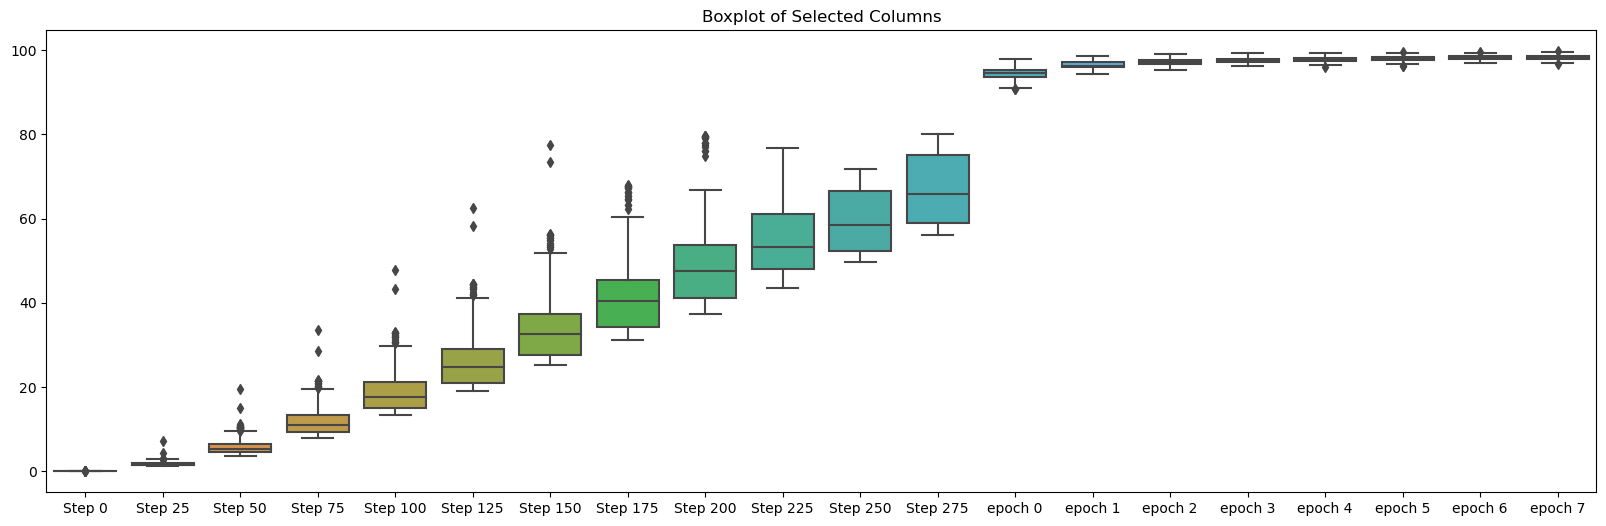

In [73]:
import seaborn as sns


# ["Actual Accuracy","Reconstructed Accuracy ID","Transformer train Loss"]+\
# ["MSE","MSE 1","MSE 2","MSE 3","MSE 4","MSE 5","KL divergence","KL 1","KL 2","KL 3","KL 4","KL 5","LWLN"]+\
# ["Wasserstein Loss","WS 1","WS 2","WS 3","WS 4","WS 5","contractive distance","N1","N11","N12","N13","N14","N15","N2","N21","N22","N23","N24","N25","saturated in pred(%)","saturated in GT(%)"]+\
# ["MSE FN","MSE 1 FN","MSE 2 FN","MSE 3 FN","MSE 4 FN","MSE 5 FN","KL divergence FN","KL 1 FN","KL 2 FN","KL 3 FN","KL 4 FN","KL 5 FN","LWLN FN"]+\
# ["Wasserstein Loss FN","WS 1 FN","WS 2 FN","WS 3 FN","WS 4 FN","WS 5 FN","contractive distance FN","N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN","N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN","saturated in pred FN(%)","saturated in GT FN(%)"]+\
# ["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
# ["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]

columns_to_plot = ["Step 0","Step 25","Step 50","Step 75","Step 100","Step 125","Step 150","Step 175","Step 200","Step 225","Step 250","Step 275","epoch 0","epoch 1","epoch 2"]+\
["epoch 3","epoch 4","epoch 5","epoch 6","epoch 7"]

# Plotting the boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(data=DF[columns_to_plot])
plt.title('Boxplot of Selected Columns')
plt.show()

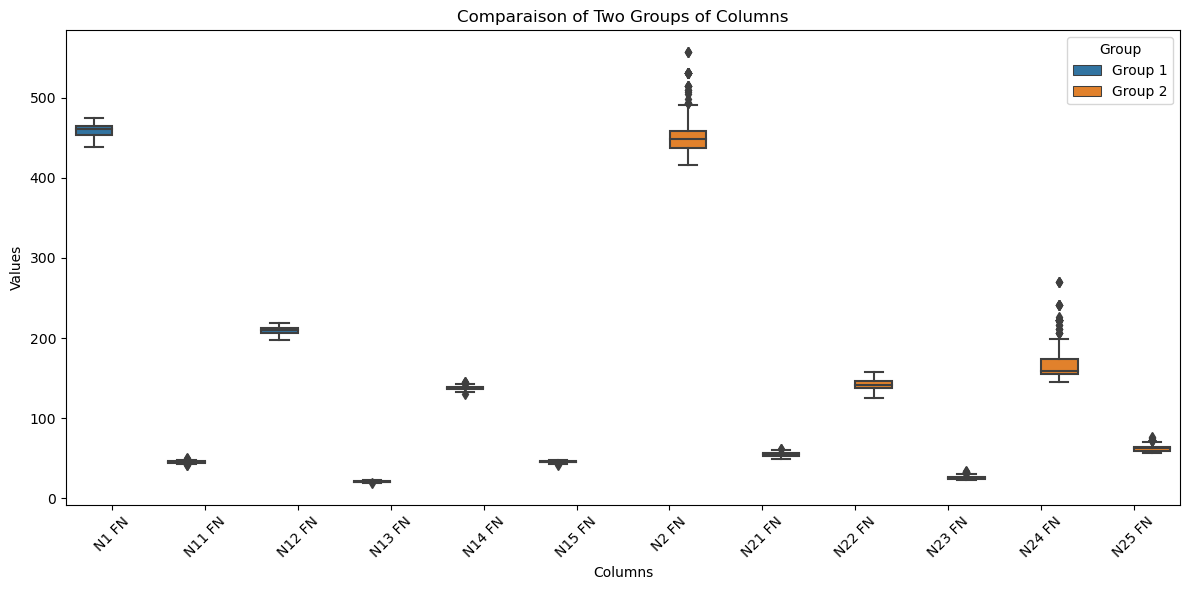

In [75]:
# Define groups of columns
df= pd.DataFrame(columns=Cols[7394:])
group1_columns = ["N1 FN","N11 FN","N12 FN","N13 FN","N14 FN","N15 FN"]
group2_columns = ["N2 FN","N21 FN","N22 FN","N23 FN","N24 FN","N25 FN"]

# Create a long-format DataFrame for seaborn
group1_melted = results[group1_columns].melt(var_name='Columns', value_name='Values')
group1_melted['Group'] = 'Group 1'

group2_melted = results[group2_columns].melt(var_name='Columns', value_name='Values')
group2_melted['Group'] = 'Group 2'

# Combine the data
melted_df = pd.concat([group1_melted, group2_melted])

# Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Columns', y='Values', hue='Group', data=melted_df)
plt.title('Comparaison of Two Groups of Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
EXP[40][0]

[0, 1, 5, 7]

In [ ]:
 if (i in [nb_batches-1] and (epoch%5==0)) or (i==0 and epoch==0):
            
            
            #print(f"Validating ... {loss_val}")
            for vect in [0,10,40,50,70]:
                y_pred=torch.unsqueeze(output[0][vect], 0) 
                y =torch.unsqueeze(tg[vect], 0) 

                selected_row = cs_tr.df.iloc[int(U[vect][0]), 11:17]  
                columns_with_one = selected_row[selected_row == 1].index.tolist()
                activ=columns_with_one
                epochCNN=cs_tr.df.loc[int(U[vect][0])]['epoch']


                checkpoint=OrderedDict()
                vector_aux= output[0][vect].detach()
                y_pred=vector_aux.cpu()

                task1=[int(x) for x in EXP[vect][0]]
                task2=[int(x) for x in EXP[vect][1]]
                task3=sorted(task1+task2)


                All=list(range(10))
                L2=[k for k in All if k not in task3] # Out of distribution classes
                L_others=[k for k in All if k not in task3] #Classes to test on (In distribution)

                checkpoint["module_list.0.weight"]=torch.tensor(np.array(y_pred[0:200]).reshape([8, 1, 5, 5]))
                checkpoint["module_list.0.bias"]=torch.tensor(np.array(y_pred[200:208]).reshape([8]))

                checkpoint["module_list.3.weight"]=torch.tensor(np.array(y_pred[208:1408]).reshape([6, 8, 5, 5]))
                checkpoint["module_list.3.bias"]=torch.tensor(np.array(y_pred[1408:1414]).reshape([6]))

                checkpoint["module_list.6.weight"]=torch.tensor(np.array(y_pred[1414:1510]).reshape([4, 6, 2, 2]))
                checkpoint["module_list.6.bias"]=torch.tensor(np.array(y_pred[1510:1514]).reshape([4]))

                checkpoint["module_list.9.weight"]=torch.tensor(np.array(y_pred[1514:2234]).reshape([20,36]))
                checkpoint["module_list.9.bias"]=torch.tensor(np.array(y_pred[2234:2254]).reshape([20]))

                checkpoint["module_list.11.weight"]=torch.tensor(np.array(y_pred[2254:2454]).reshape([10,20]))
                checkpoint["module_list.11.bias"]=torch.tensor(np.array(y_pred[2454:2464]).reshape([10]))

                Brain = CNN(1,activ[0],0,"kaiming_uniform")

                model=copy.deepcopy(Brain)
                model.load_state_dict(checkpoint)

                criterion_CNN0=CrossEntropyLoss()

                test_IF0=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/test/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Ts_DL0 = DataLoader(dataset=test_IF0, batch_size=120, num_workers=0, shuffle=False)

                _, valid_epoch_acc0,_= validate(model, Ts_DL0,  criterion_CNN0,10)
                if len(task3)==10:
                    valid_epoch_acc1=valid_epoch_acc0
                    continue
                else:
                    criterion_CNN1=CrossEntropyLoss()
                    test_IF1=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/test/",dropped_classes=[str(x) for x in task3],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                    Ts_DL1 = DataLoader(dataset=test_IF1, batch_size=120, num_workers=0, shuffle=False)

                valid_epoch_loss0, valid_epoch_acc1,L_mx= validate(model, Ts_DL1,  criterion_CNN1,10)
                cnn_acc_ID.append(valid_epoch_acc0)
                cnn_acc_OOD.append(valid_epoch_acc1)
                #lr = optimizer.param_groups[0]["lr"]
                lrE1=optimizerEnc1.param_groups[0]["lr"]
                lrE2=optimizerEnc2.param_groups[0]["lr"]
                lrL=optimizerDense.param_groups[0]["lr"]
                lrD=optimizerDec.param_groups[0]["lr"]
                
                
                
            #print(f"Reconstructing ... {valid_epoch_acc0}")
                optimizerCNN = Adam(model.parameters(), lr=0.05)
                schedulerCNN = torch.optim.lr_scheduler.CyclicLR(optimizerCNN ,base_lr=1e-3, max_lr=0.1, step_size_up=400, mode="triangular2", cycle_momentum=False)
                criterion_CNN=CrossEntropyLoss()
                
                
                train_IF0=ClassSpecificImageFolder( root="./data/SplitMnistDistilled/train/",dropped_classes=[str(x) for x in L2],transform=transforms.Compose([ transforms.ToTensor(),transforms.Grayscale(1)]))
                Tr_DLr = DataLoader(dataset=train_IF0, batch_size=100, num_workers=0, shuffle=True)
                
                
                wandb.define_metric(f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_loss train {task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_acc train{task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                
                wandb.define_metric(f"[{epoch}]CNN_fn_loss test {task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                wandb.define_metric(f"[{epoch}]CNN_fn_acc test{task1}{task2}{task3}", step_metric=f"finetune_step for epoch {epoch}")
                fine_tune_needed=0
                #print(task1,task2,task3)
                for epoch_cnn in range(15):
                    
                    # for param in model.parameters():
                    #     print(f"Param before step: {param.data[0]}")
                    #     break
                    train_epoch_loss, train_epoch_acc,_ = train(model, Tr_DLr, optimizerCNN, criterion_CNN,10)
                    valid_epoch_loss0FN, valid_epoch_acc0FN,_= validate(model, Ts_DL0,  criterion_CNN,10)
                    schedulerCNN.step()
                    # for param in model.parameters():
                    #     print(f"Param after step: {param.data[0]}")
                    #     break
                    fine_tune_needed+=1
                    #if fine_tune_needed%5==0:
                        #print(f"Accuracy of {train_epoch_acc:.2f} / ACC[vect][2] after {fine_tune_needed} epochs")
                    wandb.log({f"[{epoch}]CNN_fn_loss train {task1}{task2}{task3}":train_epoch_loss,f"[{epoch}]CNN_fn_acc train {task1}{task2}{task3}":train_epoch_acc , f"finetune_step for epoch {epoch}": fine_tune_needed})
                    wandb.log({f"[{epoch}]CNN_fn_loss test {task1}{task2}{task3}":valid_epoch_loss0FN,f"[{epoch}]CNN_fn_acc test {task1}{task2}{task3}":valid_epoch_acc0FN , f"finetune_step for epoch {epoch}": fine_tune_needed})
                    
                          
                    wandb.log({f"[{epoch}]finetune ratio {task1}{task2}{task3}":valid_epoch_acc0FN/ACC[vect][2], f"finetune_step for epoch {epoch}": fine_tune_needed})
                    wandb.log({f"combined target accuracy {task1}{task2}{task3}":ACC[vect][2], f"finetune_step for epoch {epoch}": fine_tune_needed})
                # define our custom x axis metric

            
        wandb.log({"Loss":loss_to_save})
        wandb.log({"CNN_IID_no_fine_tune":(np.mean(cnn_acc_ID))})
        wandb.log({"CNN_OOD_no_fine_tune":(np.mean(cnn_acc_OOD))})
        wandb.log({"lr Encoder 1": lrE1,"lr Encoder 2": lrE2,"lr Linear": lrL,"lr Decoder": lrD})

In [ ]:
result

In [ ]:
plt.figure(figsize=(10, 8))
hm=sns.heatmap(torch.mean( torch.mean(output[4][-1], dim=1), dim=0).detach().cpu(), annot=False, cmap='cubehelix')
plt.title('Attention Heatmap')

heatmap_path = f'heatmap 1 _step_{0}.svg'
plt.savefig(heatmap_path,format='svg', dpi=800)
plt.close()

#wandb.log({"attention_heatmap 1": wandb.Image(heatmap_path)})

In [ ]:
#https://discuss.pytorch.org/t/memory-management-using-pytorch-cuda-alloc-conf/157850
#https://stackoverflow.com/questions/73747731/runtimeerror-cuda-out-of-memory-how-can-i-set-max-split-size-mb

import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))